# Imports

In [22]:
import pandas as pd
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import time

# Utils

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures

def plot_y_yhat(y_test,y_pred, plot_title = "plot"):
    """
    Takes the values from the target variable and the predictions
    and draws the graphs for each variable. 
    Saves plots to pdf with `plot_title`.pdf
    Parameters:
        y_test (pd.DataFrame): The validation target values.
        y_pred (pd.DataFrame): The predictions target values.
        plot_title (string, optional): The title of plot.
"""
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
    MAX = 500
    if len(y_test) > MAX:
        idx = np.random.choice(len(y_test),MAX, replace=False)
    else:
        idx = np.arange(len(y_test))
    plt.figure(figsize=(10,10))
    for i in range(6):
        x0 = np.min(y_test[idx,i])
        x1 = np.max(y_test[idx,i])
        plt.subplot(3,2,i+1)
        plt.scatter(y_test[idx,i],y_pred[idx,i])
        plt.xlabel('True '+labels[i])
        plt.ylabel('Predicted '+labels[i])
        plt.plot([x0,x1],[x0,x1],color='red')
        plt.axis('square')
    plt.savefig("results/"+plot_title+'.pdf')
    plt.show()


def custom_train_test_split(X, y, test_size=0.2, drop=True, columns_to_drop=[]):
    """
    Splits the dataset into training and testing sets based on unique trajectory IDs.
    Parameters:
        X (pd.DataFrame): The feature dataset containing a 'trajectory_id' column.
        y (pd.DataFrame): The target dataset containing a 'trajectory_id' column.
        test_size (float, optional): The proportion of the dataset to include in the test split. Default is 0.2.
        drop (Boolean): Helper flag to decide weather to drop any columns or not
        columns_to_drop (list, optional): List of columns to drop from the feature dataset. Default is an empty list.
    Returns:
        tuple: A tupple containing the following:
            - X_train (pd.DataFrame): The training set of the feature dataset.
            - X_test (pd.DataFrame): The testing set of the feature dataset.
            - y_train (pd.DataFrame): The training set of the target dataset.
            - y_test (pd.DataFrame): The testing set of the target dataset.
    """
    # Get unique trajectory_ids
    unique_ids = X['trajectory_id'].unique()
    
    # Split the trajectory_ids into train and test sets
    train_ids, test_ids = train_test_split(unique_ids, test_size=test_size)

    # Split the data based on the trajectory_ids
    X_train = X[X['trajectory_id'].isin(train_ids)]
    X_test = X[X['trajectory_id'].isin(test_ids)]
    y_train = y[y['trajectory_id'].isin(train_ids)]
    y_test = y[y['trajectory_id'].isin(test_ids)]
    
    if drop:
        X_columns_drop = ['trajectory_id', 'Id'] + columns_to_drop
        Y_columns_drop = ['trajectory_id', 'Id'] + columns_to_drop

        # Drop the specified columns from X and y
        X_train = X_train.drop(columns=X_columns_drop)
        X_test = X_test.drop(columns=X_columns_drop)
        y_train = y_train.drop(columns=Y_columns_drop)
        y_test = y_test.drop(columns=Y_columns_drop)
    
    return X_train, X_test, y_train, y_test

# Rename function - GRID Search sklean
def train_model(pipeline: Pipeline,
                   X_train: pd.DataFrame, 
                   X_val: pd.DataFrame,
                   y_train: pd.DataFrame,
                   y_val: pd.DataFrame):
    """
    Evaluates the performance of a machine learning model pipeline on given data.

    This function splits the data into training and testing sets using a custom split function,
    fits the model pipeline on the training data, and then evaluates the model's performance
    on both the training and testing sets. It prints the mean squared error for both sets.

    Parameters:
        pipeline (Pipeline): The machine learning pipeline to be evaluated.
        X (pd.DataFrame): The input features for the model.
        y (pd.DataFrame): The target values for the model.
    Returns:
        y_pred_train: The prediction of the train dataset
        y_pred_val: The prediction of the validation dataset
        model: The model created
    """
    # Creates a model based on the pipeline passed
    model = pipeline.fit(X_train, y_train)
    # Check performance on train
    y_pred_train = model.predict(X_train)

    # Check performance on val
    y_pred_val = model.predict(X_val)
    return y_pred_train, y_pred_val, model

def validate_poly_regression(X_train: pd.DataFrame,
                             y_train: pd.DataFrame,
                             X_val: pd.DataFrame,
                             y_val: pd.DataFrame,
                             regressor=None, 
                             degrees=range(1,15), 
                             max_features=None,
                             verbose=False
                            ):
    
    """
    Validates polynomial regression models of varying degrees and selects the best model based on RMSE.

    Parameters:
    X_train : pd.DataFrame
        Training feature data.
    y_train : pd.DataFrame
        Training target data.
    X_val : pd.DataFrame
        Validation feature data.
    y_val : pd.DataFrame
        Validation target data.
    regressor : estimator object, default=None
        The regressor to use. If None, LinearRegression is used.
    degrees : range, default=range(1, 15)
        Range of polynomial degrees to evaluate.
    max_features : int, default=None
        Maximum number of features to consider (not used in the current implementation).
    plot : bool, default=False
        Whether to plot the results (not used in the current implementation).
    Returns:
    best_model : Pipeline
        The best polynomial regression model.
    best_rmse : float
        The RMSE of the best model.
    best_degree : int
        The degree of the polynomial features for the best model.
    """


    best_rmse = float('inf')
    best_model = None
    best_degree = None
    best_num_features = None

    for degree in degrees:
        model = make_pipeline(StandardScaler() ,PolynomialFeatures(degree=degree), regressor if regressor else LinearRegression())

        # Fit the pipeline on the training data
        if verbose:
            print("Fitting the model")
        model.fit(X_train, y_train)

        # Predict on the training model
        y_pred_train = model.predict(X_train)
        if verbose:
            print("rmse for training: "+str(root_mean_squared_error(y_train, y_pred_train)))

        # Predict on the validation data
        if verbose:
            print("Preddicting the model")
        y_pred = model.predict(X_val)

        # Calculate RMSE
        rmse = root_mean_squared_error(y_val, y_pred)
        # Print the number of features generated by PolynomialFeatures
        num_features = model.named_steps['polynomialfeatures'].n_output_features_
        if verbose:
            print(f"Degree: {degree}, RMSE: {rmse}, Number of features: {num_features}")

        # Update the best model if the current one is better
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model
            best_degree = degree
            best_num_features = num_features

    if verbose:
        print(f"Best Degree: {best_degree}, Best RMSE: {best_rmse}")
        
    return best_model, best_rmse, best_degree, best_num_features

def test_regularization(pipeline, X_train, X_val, y_train, y_val, alphas=[0.1, 1.0, 10.0, 100.0], regressor_type='lasso'):
    best_rmse = float('inf')
    best_model = None
    for alpha in alphas:
        if regressor_type == 'lasso':
            pipeline.set_params(regressor=Lasso(alpha=alpha))
        elif regressor_type == 'ridge':
            pipeline.set_params(regressor=Ridge(alpha=alpha))
        else:
            raise ValueError("regressor_type must be either 'lasso' or 'ridge'")
        
        y_pred_train, y_pred_val, model = train_model(pipeline, X_train, X_val, y_train, y_val)
        train_rmse = root_mean_squared_error(y_pred_train, y_train)
        val_rmse = root_mean_squared_error(y_pred_val, y_val)
        print(f"alpha: {alpha}, train: {train_rmse}, validation: {val_rmse}")
        if val_rmse < best_rmse:
            best_rmse = val_rmse
            best_model = model
    return best_model, best_rmse



In [24]:
df = pd.read_csv("../data/mlNOVA/mlNOVA/X_train.csv")

# Model Analysis for the Three Body Problem
The problem consists in predicting positions at an instant t given a set of initial positions. <br>
This problem will be aproached as a multivariate regression, and we'll compare the results of using different types of regressions.

In [25]:
# Cleaning the data
# Create the trajectory_id column
df['trajectory_id'] = df['Id'] // 257
# Filter out rows where all columns except 'Id' and trajectory_Id are zero
df_filtered = df.loc[~(df.drop(columns=['Id','trajectory_id']) == 0).all(axis=1)]
df[df['trajectory_id'] == 157]

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id,trajectory_id
40349,0.000000,1.000000,0.000000,0.000000,0.000000,-0.006029,0.411829,0.000000,0.000000,-0.993971,-0.411829,0.000000,0.000000,40349,157
40350,0.039062,0.999222,0.000207,-0.039848,0.010623,-0.005786,0.411289,0.012472,-0.027653,-0.993436,-0.411497,0.027376,0.017030,40350,157
40351,0.078125,0.996885,0.000830,-0.079867,0.021279,-0.005053,0.409668,0.025035,-0.055369,-0.991831,-0.410499,0.054831,0.034089,40351,157
40352,0.117188,0.992978,0.001871,-0.120228,0.032003,-0.003827,0.406962,0.037782,-0.083211,-0.989151,-0.408833,0.082446,0.051208,40352,157
40353,0.156250,0.987485,0.003332,-0.161116,0.042829,-0.002098,0.403165,0.050812,-0.111244,-0.985387,-0.406497,0.110303,0.068415,40353,157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40601,9.843750,-2.502845,0.957132,-0.401091,0.204687,1.165911,-0.700134,0.690975,0.042212,1.336935,-0.256998,-0.289884,-0.246899,40601,157
40602,9.882810,-2.518426,0.965095,-0.396626,0.202979,1.194048,-0.695157,0.748944,0.217154,1.324377,-0.269938,-0.352318,-0.420133,40602,157
40603,9.921880,-2.533833,0.972990,-0.392213,0.201291,1.224357,-0.682701,0.801769,0.428515,1.309476,-0.290289,-0.409556,-0.629806,40603,157
40604,9.960940,-2.549068,0.980821,-0.387851,0.199620,1.256559,-0.660818,0.844334,0.707369,1.292509,-0.320003,-0.456483,-0.906990,40604,157


## Data Preparation

In [26]:
# Cleaning the data
# Create the trajectory_id column
df['trajectory_id'] = df['Id'] // 257
# Filter out rows where all columns except 'Id' and trajectory_Id are zero
df_filtered = df.loc[~(df.drop(columns=['Id','trajectory_id']) == 0).all(axis=1)]

# Features
# Group by 'trajectory_id' and get the first occurrence of each group
first_occurrence = df_filtered.groupby('trajectory_id').first().reset_index()
# Merge first occurrence back to the original dataframe, only replacing columns that need to be kept constant
columns_to_replace = df_filtered.columns.difference(['t', 'trajectory_id', 'Id'])  # Columns to replace except 't' and 'trajectory_id'
# We merge 'first_occurrence' on 'trajectory_id' with the original dataframe,
# and only replace the required columns.
X_raw = df_filtered[['t', 'trajectory_id', 'Id']].merge(
    first_occurrence[['trajectory_id'] + list(columns_to_replace)],
    on='trajectory_id',
    how='left'
)
# Reorder the columns
# Features
X_raw = X_raw[['t', 'x_1', 'y_1', 'v_x_1', 'v_y_1', 'x_2', 'y_2', 'v_x_2', 'v_y_2', 'x_3', 'y_3', 'v_x_3', 'v_y_3', 'Id', 'trajectory_id']]
X_raw = X_raw[X_raw['t'] != 0] # Removing the t = 0

# Target
Y_raw =df_filtered[df_filtered['t'] != 0] # Removing the t = 0
Y_raw = Y_raw[['x_1', 'y_1', 'v_x_1', 'v_y_1', 'x_2', 'y_2', 'v_x_2', 'v_y_2', 'x_3', 'y_3', 'v_x_3', 'v_y_3', 'Id', 'trajectory_id']]

# Permanent test data
# First, remove 10% of the data to use as a fixed test set
X_train_val, X_test, y_train_val, y_test = custom_train_test_split(X_raw, Y_raw, test_size=0.1, drop=False)
X_test.drop(columns=['trajectory_id', 'Id'])
y_test.drop(columns=['trajectory_id', 'Id', 'v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'])

X = X_train_val
y = y_train_val

## Data split

This will be data training, validation sets to improve the model performance. These sets will have the trajectory_id and id columns (makes easier to sample smaller data)

In [27]:
X_train, X_val, y_train, y_val = custom_train_test_split(X_train_val, y_train_val, drop=False, test_size=0.1)

## Linear Regression

In [28]:
info_columns = ['trajectory_id', 'Id']
velocity_columns = ['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3']

X_train_reg = X_train.drop(columns=info_columns+velocity_columns)
y_train_reg = y_train.drop(columns=info_columns+velocity_columns)
X_val_reg = X_val.drop(columns=info_columns+velocity_columns)
y_val_reg = y_val.drop(columns=info_columns+velocity_columns)

Normal linear regression
train: 1.430655326400449
validation: 1.1493341488201405


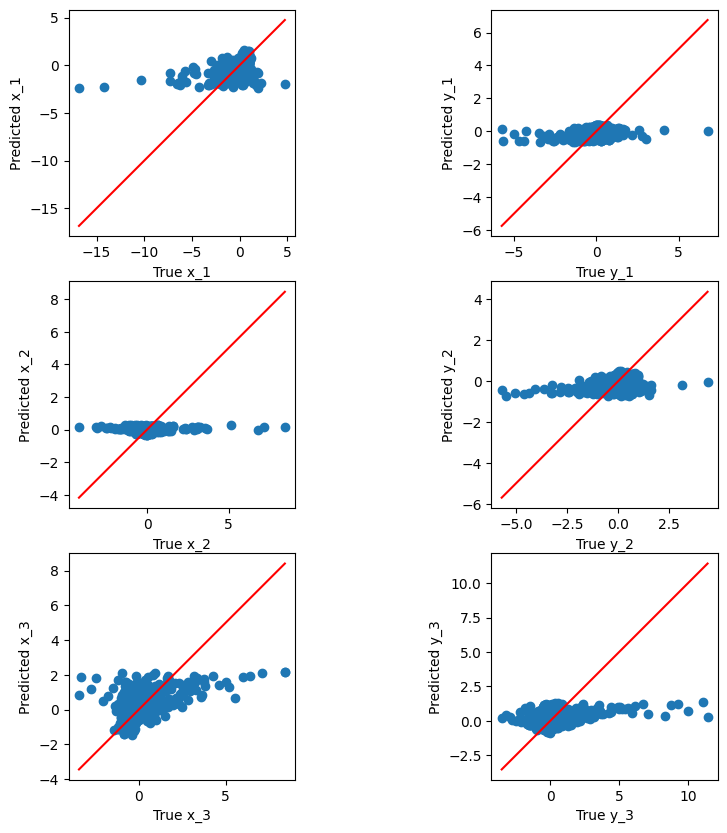

Regularizations
Ridge regression
alpha: 0.1, train: 1.4306747177101158, validation: 1.1492951886220573
alpha: 1.0, train: 1.4306747177101837, validation: 1.1492951663305486
alpha: 10.0, train: 1.4306747177165142, validation: 1.1492949434242743
alpha: 100.0, train: 1.4306747183509527, validation: 1.149292715237704
1.149292715237704


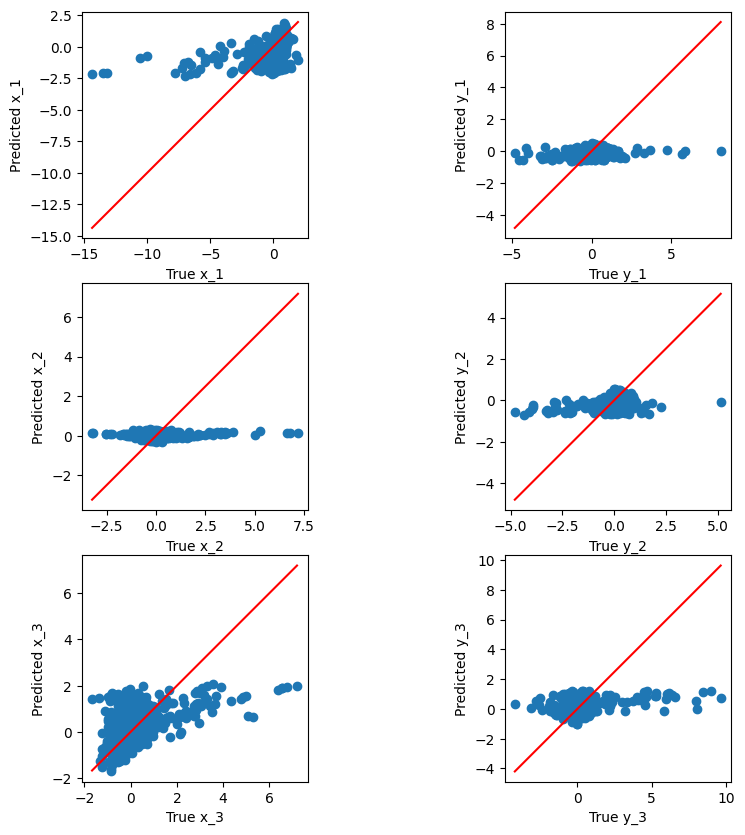

Lasso regression
alpha: 0.1, train: 1.4389871940944292, validation: 1.1505211017050494
alpha: 1.0, train: 1.5149085293163704, validation: 1.2164053785546363
alpha: 10.0, train: 1.5149085293163704, validation: 1.2164053785546363
alpha: 100.0, train: 1.5149085293163704, validation: 1.2164053785546363
1.1505211017050494


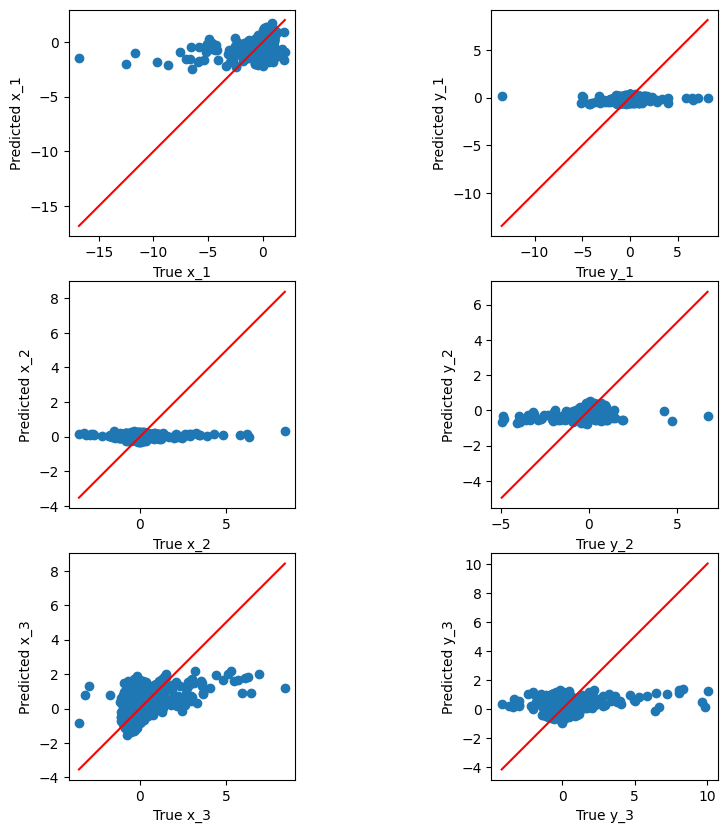

In [29]:
print("Normal linear regression")
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression()) 
])
y_pred_train, y_pred_val, linear_model = train_model(pipeline, X_train_reg, X_val_reg, y_train_reg, y_val_reg)

print("train: "+str(root_mean_squared_error(y_pred_train, y_train_reg)))
print("validation: "+str(root_mean_squared_error(y_pred_val, y_val_reg)))
plot_y_yhat(np.array(y_val_reg), np.array(y_pred_val), "Linear Regression")

print("Regularizations")
print("Ridge regression")
best_model_ridge, best_rmse = test_regularization(pipeline, X_train_reg, X_val_reg, y_train_reg, y_val_reg, regressor_type='ridge')
print(best_rmse)
best_model_ridge.predict(X_val_reg)
plot_y_yhat(np.array(y_val_reg), np.array(y_pred_val), "Linear Regression Ridge")

print("Lasso regression")
best_model_lasso, best_rmse = test_regularization(pipeline, X_train_reg, X_val_reg, y_train_reg, y_val_reg, regressor_type='lasso')
print(best_rmse)
best_model_lasso.predict(X_val_reg)
plot_y_yhat(np.array(y_val_reg), np.array(y_pred_val), "Linear Regression Lasso")

In [30]:
# Test the best linear regression
y_test_pred = linear_model.predict(X_test.drop(columns=info_columns+velocity_columns))
print(root_mean_squared_error(y_test_pred, y_test.drop(columns=info_columns+velocity_columns)))

# Test with the X_test
df_X_test = pd.read_csv("../data/mlNOVA/mlNOVA/X_test.csv")
df_X_test.rename(columns={'x0_1': 'x_1', 'y0_1': 'y_1', 'x0_2': 'x_2', 'y0_2': 'y_2', 'x0_3': 'x_3', 'y0_3': 'y_3'}, inplace=True)
df_X_test = df_X_test[['t', 'x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3', 'Id']]
y_test_real_pred = linear_model.predict(df_X_test.drop(columns=['Id']))
submission = pd.DataFrame({
    'Id': df_X_test['Id'],
    'x_1': y_test_real_pred[:, 0],
    'y_1': y_test_real_pred[:, 1],
    'x_2': y_test_real_pred[:, 2],
    'y_2': y_test_real_pred[:, 3],
    'x_3': y_test_real_pred[:, 4],
    'y_3': y_test_real_pred[:, 5]
})

# Save the submission file
submission.to_csv('results/baseline-model.csv', index=False)

1.2379656947760778


## Polynomial Linear Regressions

Choosing the best degree

In [31]:
def evaluate_polynomial(X, y, X_val, y_val, plot_title, regressor=None, ite=20, degrees=range(1,7), sample_size=0.01):
    best_rmse_list = []
    # Store key value, degree and rmse
    best_degree_list = []
    print(degrees)
    degree_rmse_map = {}

    for _ in range(ite):
        unique_ids = X['trajectory_id'].unique()
        sampled_ids = np.random.choice(unique_ids, size=int(len(unique_ids) * sample_size), replace=False)
        X_train_sampled = X[X['trajectory_id'].isin(sampled_ids)]
        y_train_sampled = y[y['trajectory_id'].isin(sampled_ids)]
        X_train = X_train_sampled.drop(columns=info_columns+velocity_columns)
        y_train = y_train_sampled.drop(columns=info_columns+velocity_columns)
        
        best_model, best_rmse, best_degree, best_num_features = validate_poly_regression(X_train, y_train, X_val, y_val, regressor=regressor, degrees=degrees, verbose=False)
        best_degree_list.append(best_degree)
        best_rmse_list.append(best_rmse)
        if best_degree in degree_rmse_map:
            degree_rmse_map[best_degree]['frequency'] += 1
            degree_rmse_map[best_degree]['total_rmse'] += best_rmse
        else:
            degree_rmse_map[best_degree] = {'frequency': 1, 'total_rmse': best_rmse}
        

    # Plot Bar plot of each histogram
    # plot the Loss over Degrees
    plt.figure(figsize=(10, 6))
    unique_degrees, counts = np.unique(best_degree_list, return_counts=True)
    plt.bar(unique_degrees, counts, tick_label=unique_degrees)
    most_occuring_degree = max(degree_rmse_map, key=lambda k: degree_rmse_map[k]['frequency'])
    average_rmse = degree_rmse_map[most_occuring_degree]['total_rmse'] / degree_rmse_map[most_occuring_degree]['frequency']
    print(f"Most occurring degree: {most_occuring_degree}, Average RMSE: {average_rmse}")
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.title(plot_title)
    plt.show()
    return average_rmse, most_occuring_degree

def plot_poly_evolution(avg_rmse_list, best_degrees_list, sample_size_list): 
    plt.figure(figsize=(12, 6))

    # Plotting the average RMSE
    plt.subplot(1, 2, 1)
    plt.plot(sample_size_list, avg_rmse_list, marker='o')
    plt.xlabel('Sample Size')
    plt.ylabel('Average RMSE')
    plt.title('Average RMSE vs Sample Size')

    # Plotting the best degrees
    plt.subplot(1, 2, 2)
    plt.plot(sample_size_list, best_degrees_list, marker='o', color='orange')
    plt.xlabel('Sample Size')
    plt.ylabel('Best Degree')
    plt.title('Best Degree vs Sample Size')

    plt.tight_layout()
    plt.show()

In [32]:
X_val_poly = X_val.drop(columns=info_columns+velocity_columns)
y_val_poly = y_val.drop(columns=info_columns+velocity_columns)

range(1, 7)
Most occurring degree: 3, Average RMSE: 1.4234543294670852


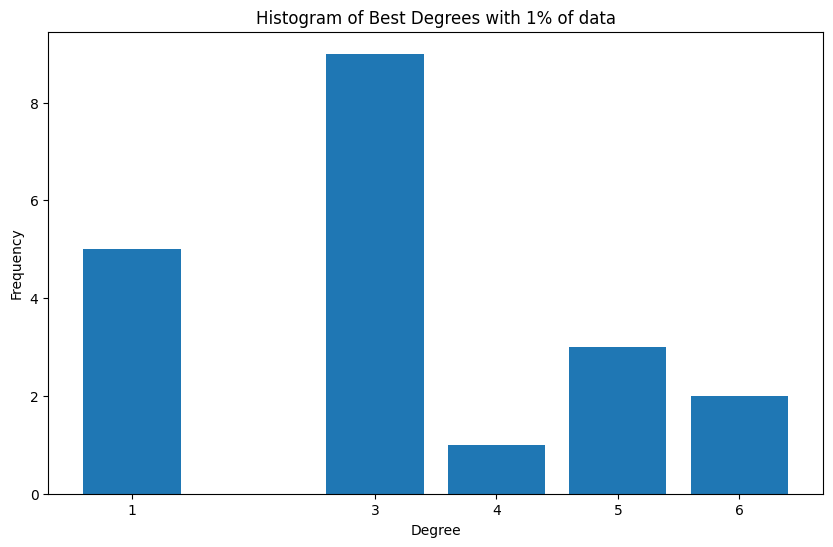

range(1, 7)
Most occurring degree: 1, Average RMSE: 1.4100138039424723


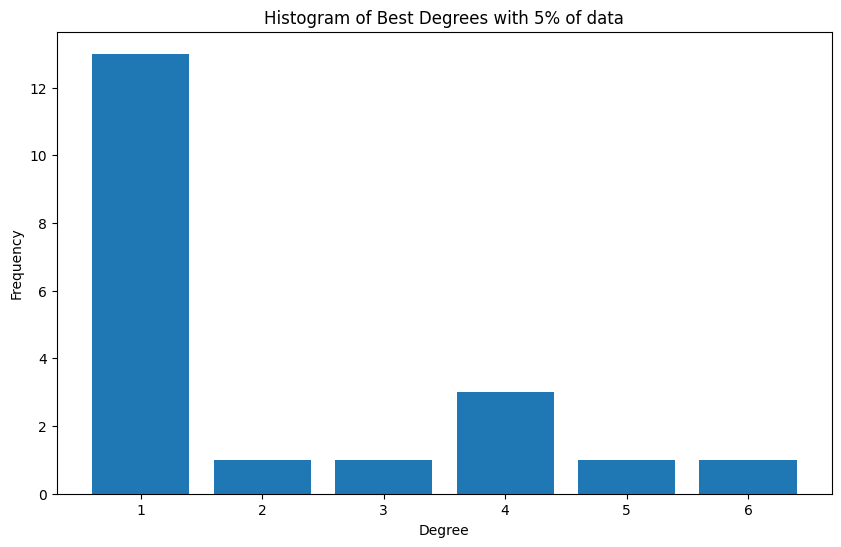

range(1, 7)
Most occurring degree: 1, Average RMSE: 1.3518498437789588


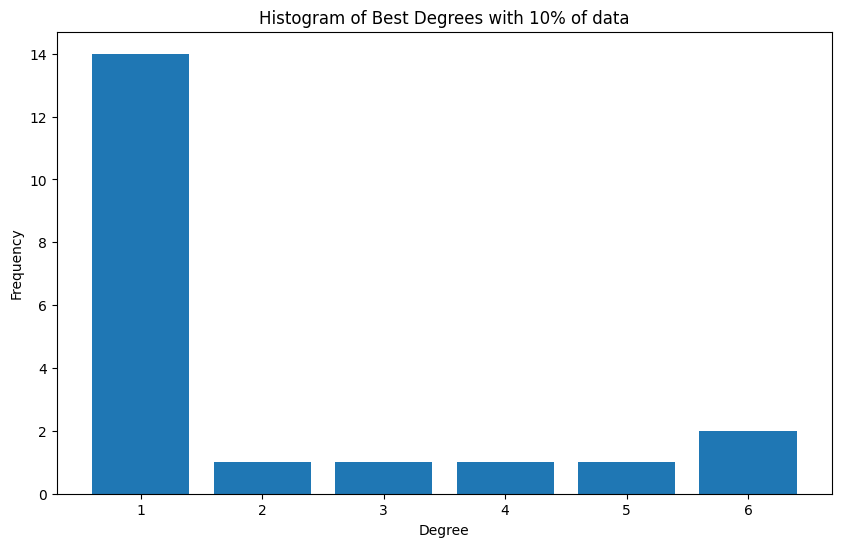

range(1, 7)
Most occurring degree: 1, Average RMSE: 1.2416523578942682


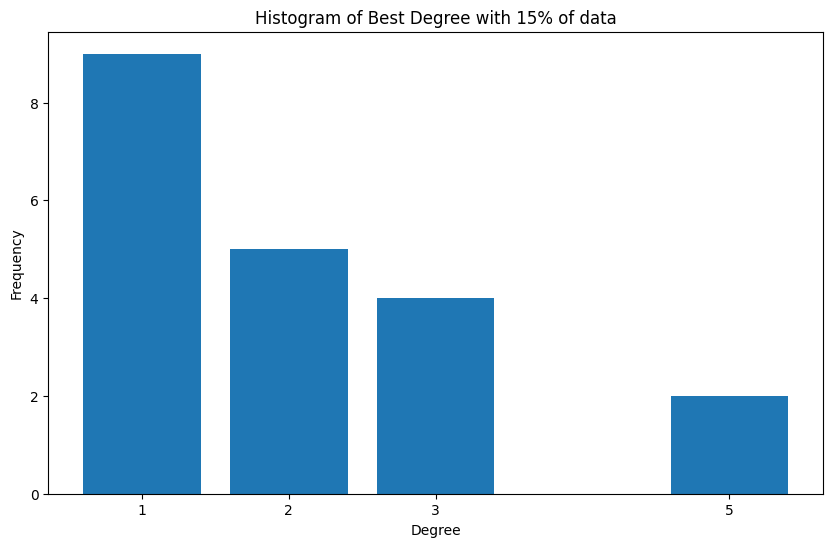

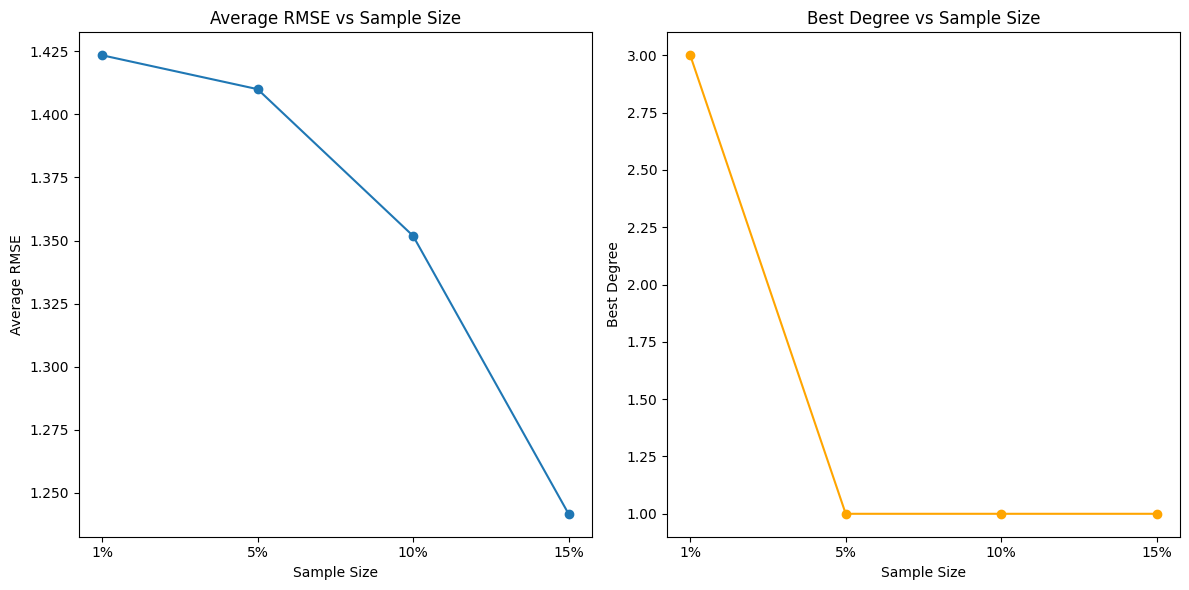

In [33]:
avg_rmse_list = []
best_degrees_list = []
data_sample_list = []
average_rmse, most_occuring_degree = evaluate_polynomial(X_train, y_train, X_val_poly, y_val_poly, "Histogram of Best Degrees with 1% of data")
data_sample_list.append("1%")
avg_rmse_list.append(average_rmse)
best_degrees_list.append(most_occuring_degree)
average_rmse, most_occuring_degree = evaluate_polynomial(X_train, y_train, X_val_poly, y_val_poly, "Histogram of Best Degrees with 5% of data", sample_size=0.05)
data_sample_list.append("5%")
avg_rmse_list.append(average_rmse)
best_degrees_list.append(most_occuring_degree)
average_rmse, most_occuring_degree = evaluate_polynomial(X_train, y_train, X_val_poly, y_val_poly, "Histogram of Best Degrees with 10% of data", sample_size=0.10)
data_sample_list.append("10%")
avg_rmse_list.append(average_rmse)
best_degrees_list.append(most_occuring_degree)
average_rmse, most_occuring_degree = evaluate_polynomial(X_train, y_train, X_val_poly, y_val_poly, "Histogram of Best Degree with 15% of data", sample_size=0.15)
data_sample_list.append("15%")
avg_rmse_list.append(average_rmse)
best_degrees_list.append(most_occuring_degree)

plot_poly_evolution(avg_rmse_list, best_degrees_list, data_sample_list)

### Ridge Regressor

range(1, 7)
Most occurring degree: 1, Average RMSE: 1.2027722342641631


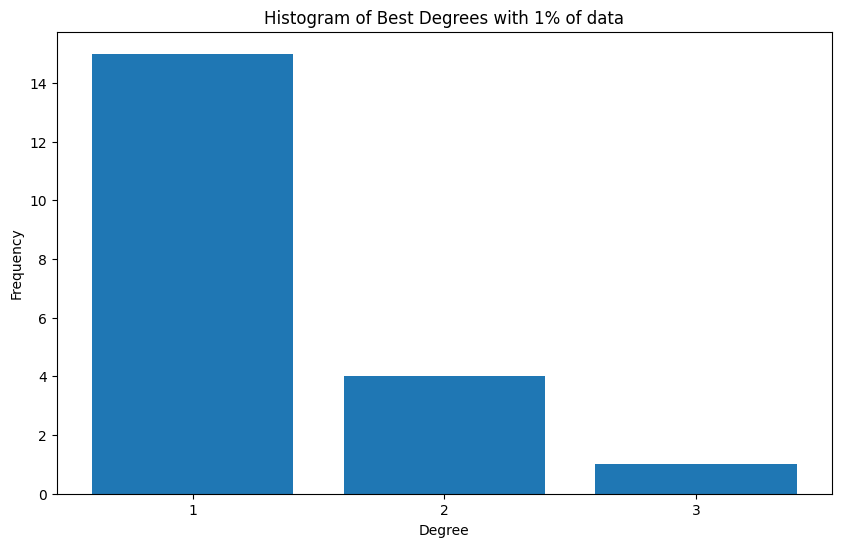

range(1, 7)
Most occurring degree: 6, Average RMSE: 1.075007434981283


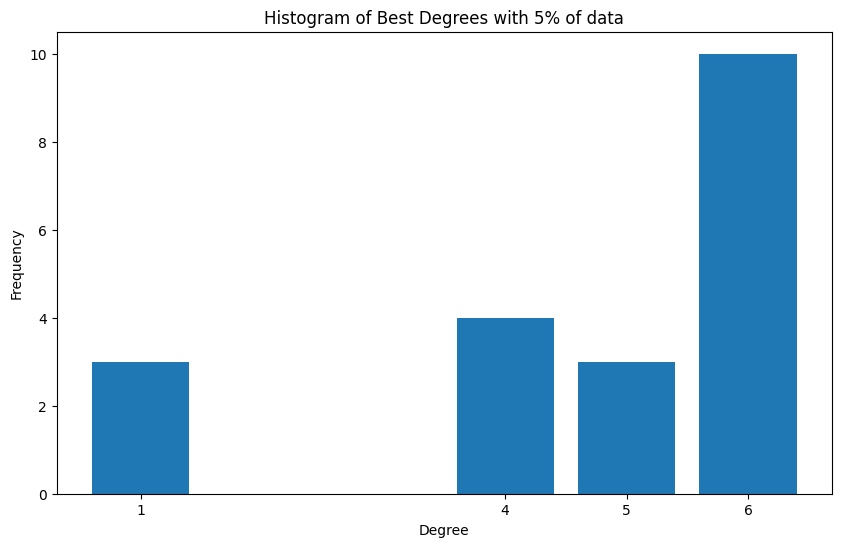

range(1, 7)
Most occurring degree: 6, Average RMSE: 1.0416279594133824


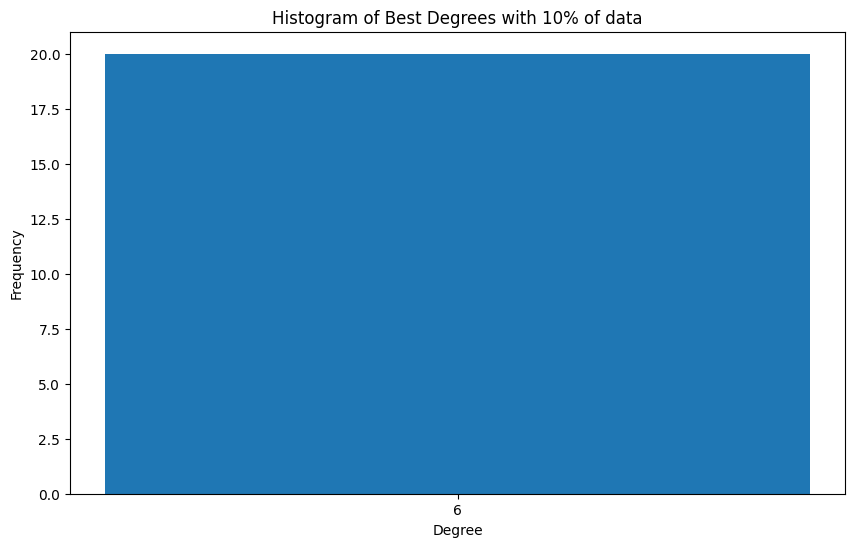

range(1, 7)
Most occurring degree: 6, Average RMSE: 1.0320356761443878


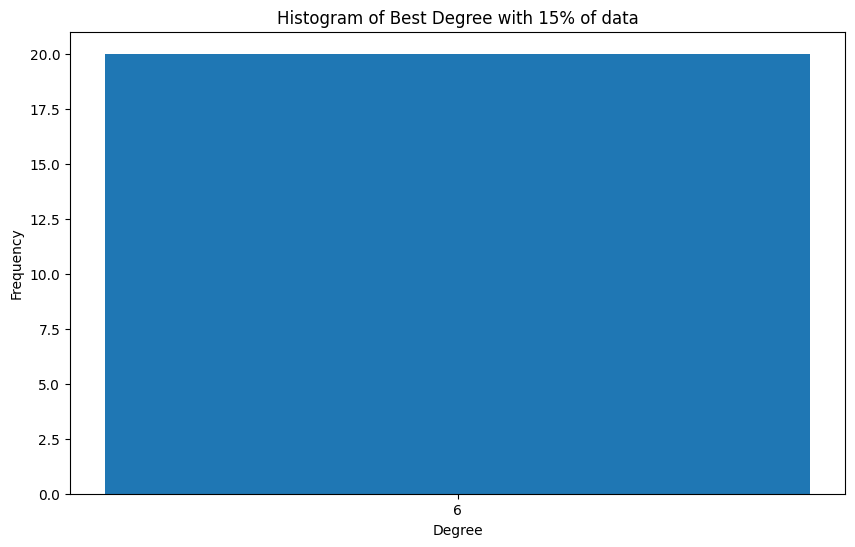

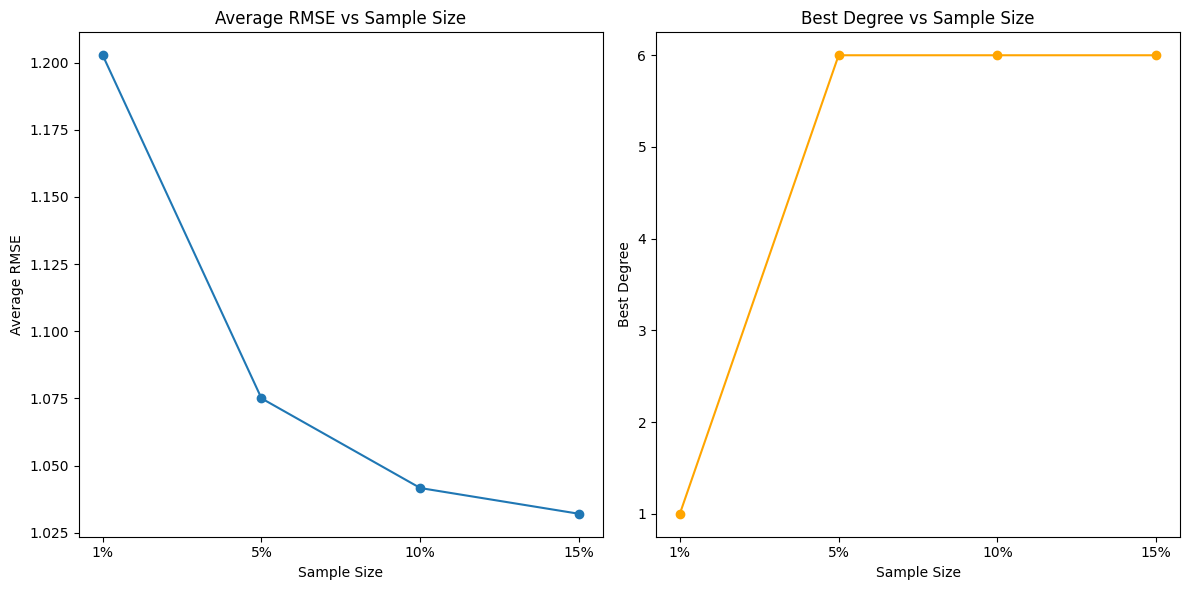

In [34]:
avg_rmse_list = []
best_degrees_list = []
data_sample_list = []
average_rmse, most_occuring_degree = evaluate_polynomial(X_train, y_train, X_val_poly, y_val_poly, "Histogram of Best Degrees with 1% of data", regressor=Ridge())
data_sample_list.append("1%")
avg_rmse_list.append(average_rmse)
best_degrees_list.append(most_occuring_degree)
average_rmse, most_occuring_degree = evaluate_polynomial(X_train, y_train, X_val_poly, y_val_poly, "Histogram of Best Degrees with 5% of data", regressor=Ridge(), sample_size=0.05)
data_sample_list.append("5%")
avg_rmse_list.append(average_rmse)
best_degrees_list.append(most_occuring_degree)
average_rmse, most_occuring_degree = evaluate_polynomial(X_train, y_train, X_val_poly, y_val_poly, "Histogram of Best Degrees with 10% of data", regressor=Ridge(), sample_size=0.10)
data_sample_list.append("10%")
avg_rmse_list.append(average_rmse)
best_degrees_list.append(most_occuring_degree)
average_rmse, most_occuring_degree = evaluate_polynomial(X_train, y_train, X_val_poly, y_val_poly, "Histogram of Best Degree with 15% of data", regressor=Ridge(), sample_size=0.15)
data_sample_list.append("15%")
avg_rmse_list.append(average_rmse)
best_degrees_list.append(most_occuring_degree)

plot_poly_evolution(avg_rmse_list, best_degrees_list, data_sample_list)

### Lasso Regressor

range(1, 7)
Most occurring degree: 6, Average RMSE: 1.1900404263917954


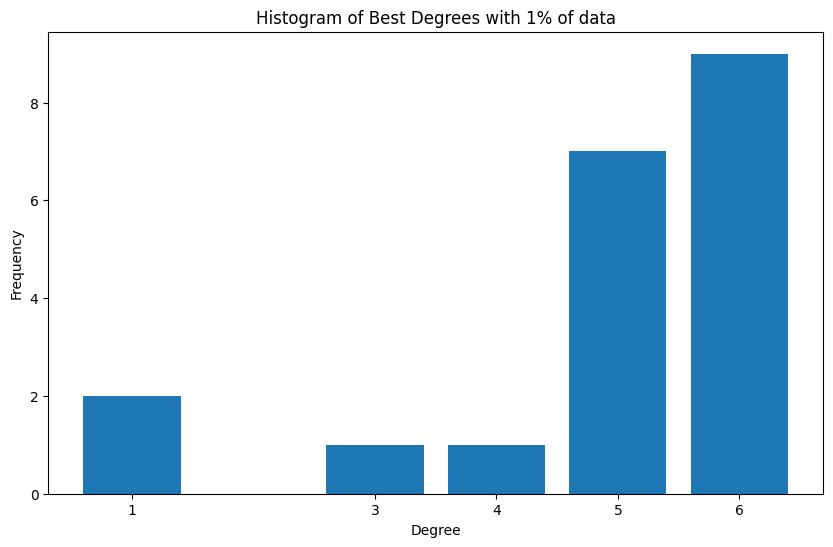

range(1, 7)
Most occurring degree: 6, Average RMSE: 1.179871176857977


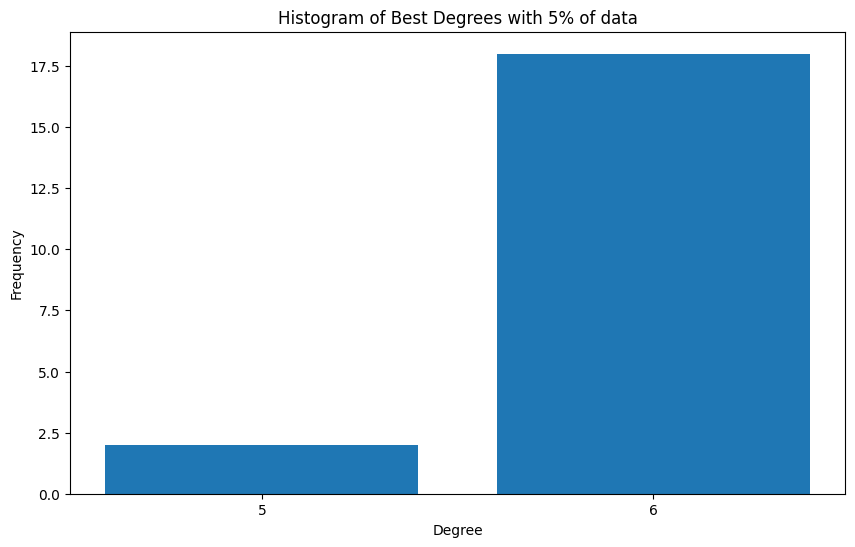

range(1, 7)
Most occurring degree: 6, Average RMSE: 1.1783578498604728


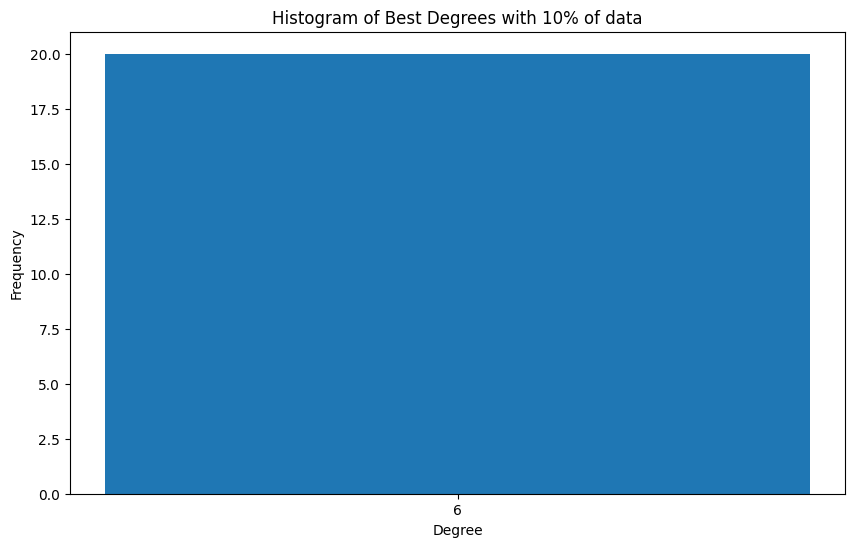

range(1, 7)
Most occurring degree: 6, Average RMSE: 1.1771750363261828


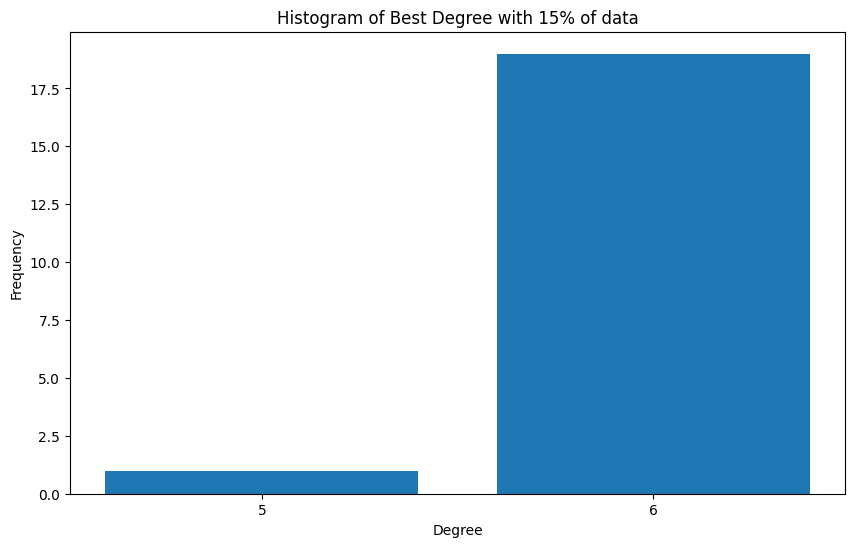

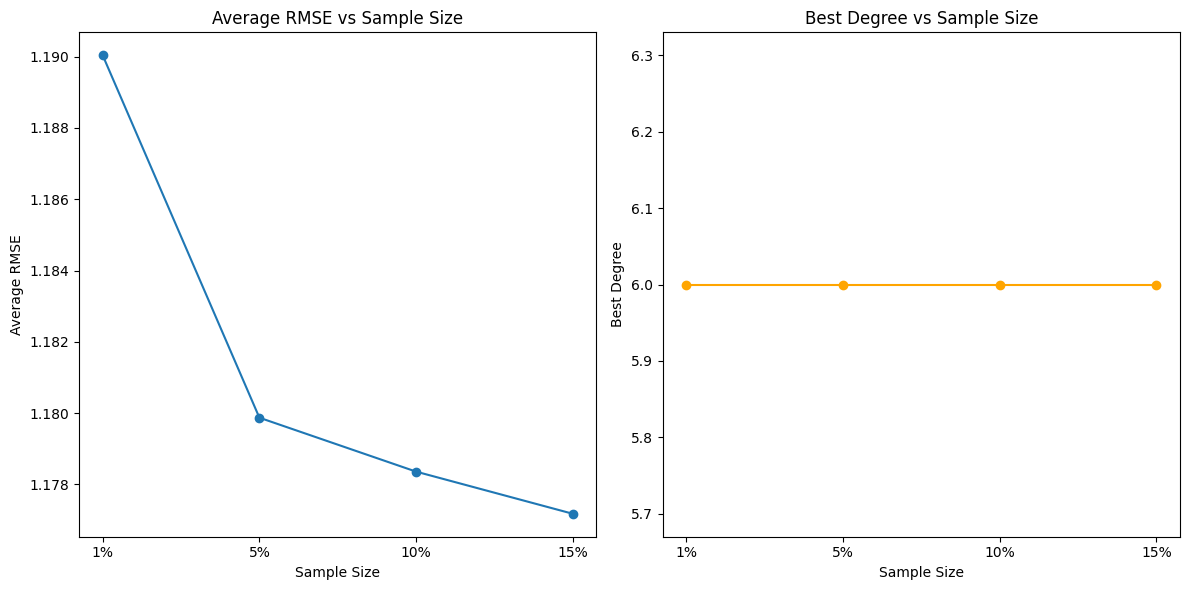

In [35]:
avg_rmse_list = []
best_degrees_list = []
data_sample_list = []
average_rmse, most_occuring_degree = evaluate_polynomial(X_train, y_train, X_val_poly, y_val_poly, "Histogram of Best Degrees with 1% of data", regressor=Lasso())
data_sample_list.append("1%")
avg_rmse_list.append(average_rmse)
best_degrees_list.append(most_occuring_degree)
average_rmse, most_occuring_degree = evaluate_polynomial(X_train, y_train, X_val_poly, y_val_poly, "Histogram of Best Degrees with 5% of data", regressor=Lasso(), sample_size=0.05)
data_sample_list.append("5%")
avg_rmse_list.append(average_rmse)
best_degrees_list.append(most_occuring_degree)
average_rmse, most_occuring_degree = evaluate_polynomial(X_train, y_train, X_val_poly, y_val_poly, "Histogram of Best Degrees with 10% of data", regressor=Lasso(), sample_size=0.10)
data_sample_list.append("10%")
avg_rmse_list.append(average_rmse)
best_degrees_list.append(most_occuring_degree)
average_rmse, most_occuring_degree = evaluate_polynomial(X_train, y_train, X_val_poly, y_val_poly, "Histogram of Best Degree with 15% of data", regressor=Lasso(), sample_size=0.15)
data_sample_list.append("15%")
avg_rmse_list.append(average_rmse)
best_degrees_list.append(most_occuring_degree)

plot_poly_evolution(avg_rmse_list, best_degrees_list, data_sample_list)

In [36]:
info_columns = ['trajectory_id', 'Id']
velocity_columns = ['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3']

X_train_poly = X_train.drop(columns=info_columns+velocity_columns)
y_train_poly = y_train.drop(columns=info_columns+velocity_columns)
X_val_poly = X_val.drop(columns=info_columns+velocity_columns)
y_val_poly = y_val.drop(columns=info_columns+velocity_columns)

# Best degree was with Ridge degree 6
model = make_pipeline(StandardScaler(), PolynomialFeatures(degree=6), Ridge())
polynomial_model = model.fit(X_train_poly, y_train_poly)

# TODO - test diferent alphas for ridge

In [37]:
y_pred_val = polynomial_model.predict(X_val_poly)
print("rmse for train: "+str(root_mean_squared_error(y_pred_train, y_train_poly)))
print("rmse for validation: "+str(root_mean_squared_error(y_pred_val, y_val_poly)))

rmse for train: 1.430655326400449
rmse for validation: 1.0041194112261411


In [38]:
# Test with the X_test
df_X_test = pd.read_csv("../data/mlNOVA/mlNOVA/X_test.csv")
df_X_test.rename(columns={'x0_1': 'x_1', 'y0_1': 'y_1', 'x0_2': 'x_2', 'y0_2': 'y_2', 'x0_3': 'x_3', 'y0_3': 'y_3'}, inplace=True)
df_X_test = df_X_test[['t', 'x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3', 'Id']]
y_test_real_pred = polynomial_model.predict(df_X_test.drop(columns=['Id']))
submission = pd.DataFrame({
    'Id': df_X_test['Id'],
    'x_1': y_test_real_pred[:, 0],
    'y_1': y_test_real_pred[:, 1],
    'x_2': y_test_real_pred[:, 2],
    'y_2': y_test_real_pred[:, 3],
    'x_3': y_test_real_pred[:, 4],
    'y_3': y_test_real_pred[:, 5]
})

# Save the submission file
submission.to_csv('results/polynomial_submission.csv', index=False)

## Feature Engineering

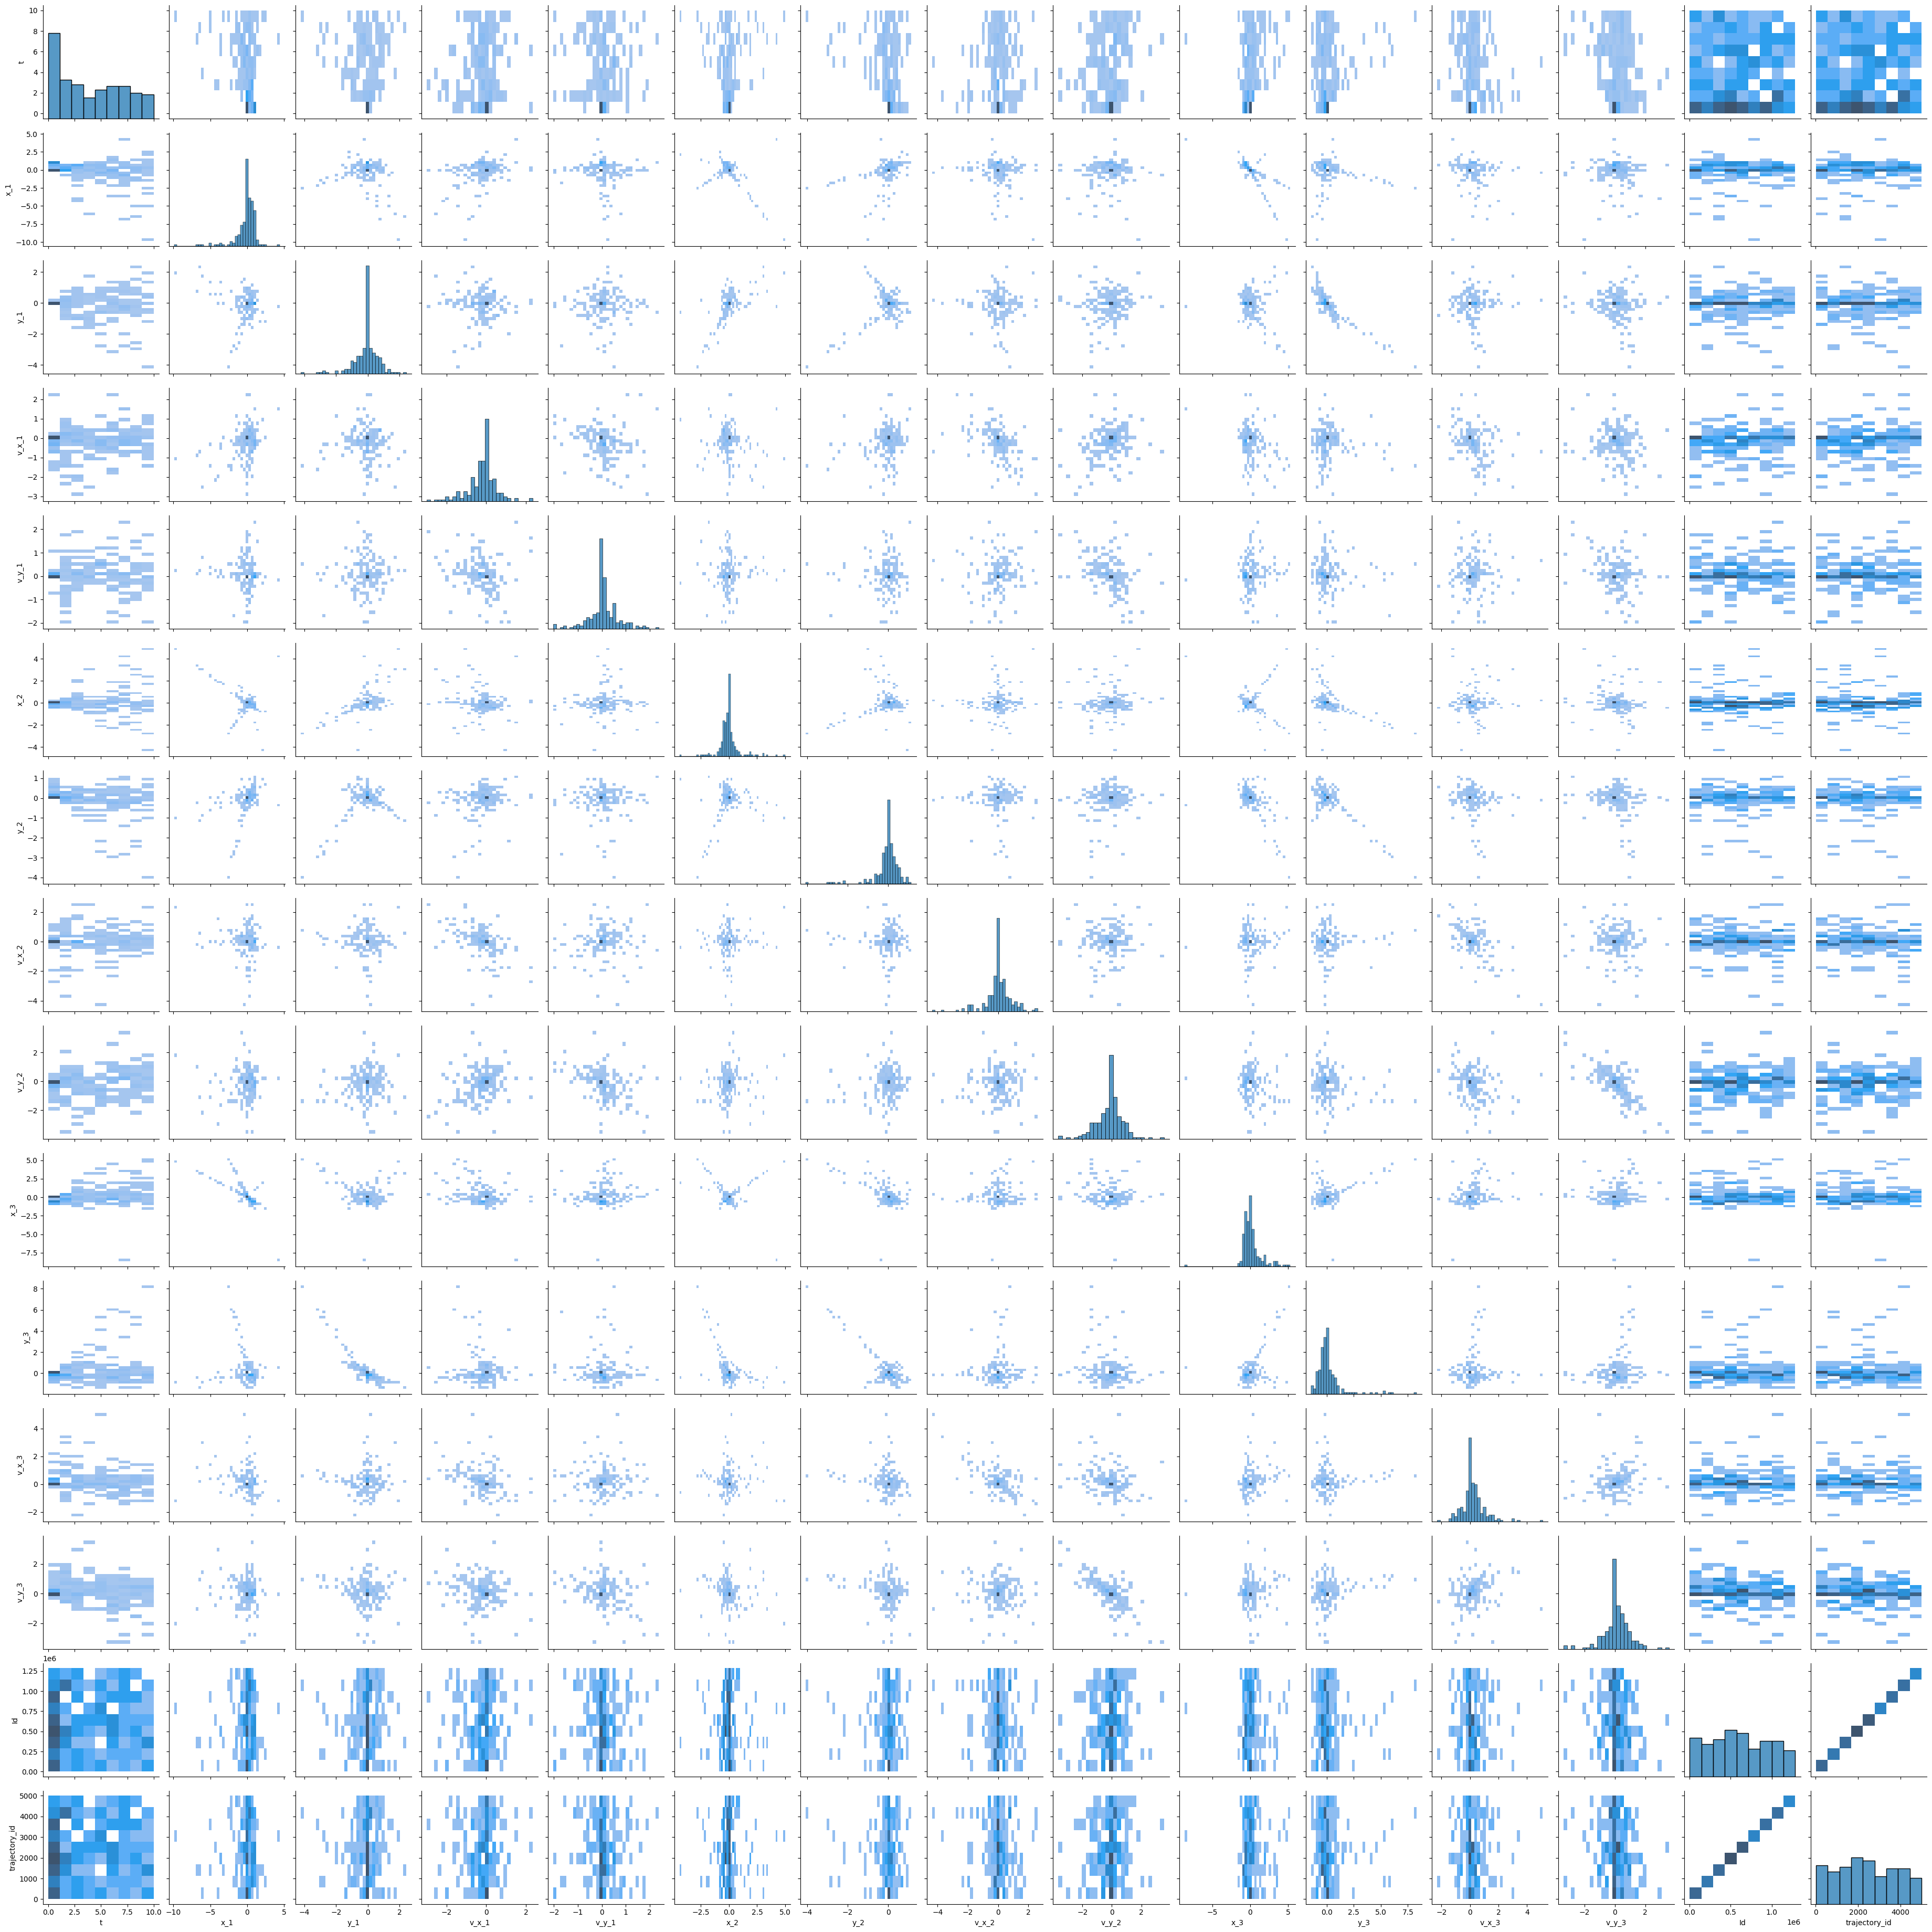

In [39]:
sns.pairplot(df.sample(200), kind="hist")

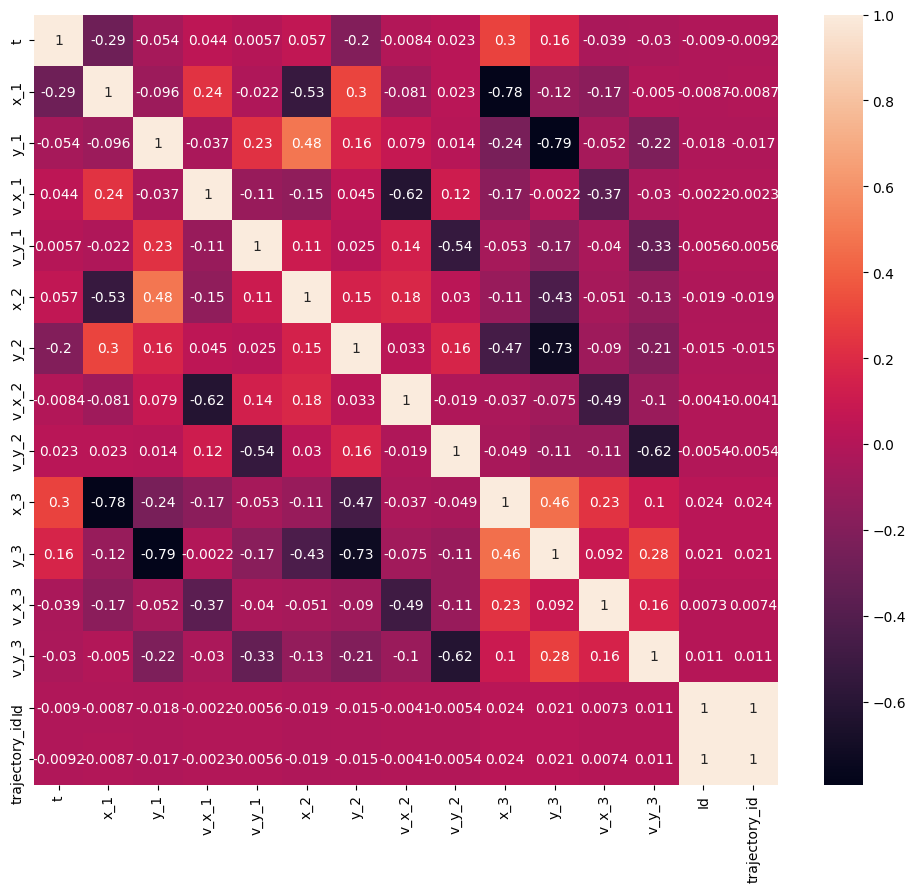

In [47]:
corr = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True)
plt.show()

In [48]:
# Sort the interactions by the absolute value of the correlations
sorted_corr = corr.abs().unstack().sort_values(ascending=False).drop_duplicates()
print(sorted_corr.to_string())

t              t                1.000000
trajectory_id  Id               1.000000
y_1            y_3              0.793226
x_1            x_3              0.782191
y_3            y_2              0.728914
v_x_1          v_x_2            0.624286
v_y_2          v_y_3            0.623556
v_y_1          v_y_2            0.535823
x_1            x_2              0.533159
v_x_2          v_x_3            0.492970
x_2            y_1              0.483959
x_3            y_2              0.465291
y_3            x_3              0.455773
               x_2              0.429479
v_x_3          v_x_1            0.371922
v_y_1          v_y_3            0.325963
x_1            y_2              0.300793
x_3            t                0.296122
x_1            t                0.287582
y_3            v_y_3            0.282318
y_1            x_3              0.243170
v_x_1          x_1              0.235357
x_3            v_x_3            0.231890
y_1            v_y_1            0.225161
               v

In [49]:
info_columns = ['trajectory_id', 'Id']
velocity_columns = ['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3']

X_train_reg_FE = X_train.drop(columns=info_columns)
y_train_reg_FE = y_train.drop(columns=info_columns)
X_val_reg_FE = X_val.drop(columns=info_columns)
y_val_reg_FE = y_val.drop(columns=info_columns)

y_1    y_3      0.793226
x_1    x_3      0.782191
y_3    y_2      0.728914
v_x_1  v_x_2    0.624286
v_y_2  v_y_3    0.623556
                  ...   
Id     v_y_2    0.005433
x_1    v_y_3    0.004981
v_x_2  Id       0.004092
v_x_1  Id       0.002233
       y_3      0.002227
Length: 78, dtype: float64
Baseline RMSE: 1.0041194112261411
Eliminating variable: y_3 (correlation with y_1: 0.7932262027734588)
Train RMSE: 1.192101333271323, Validation RMSE: 1.0326958072461576


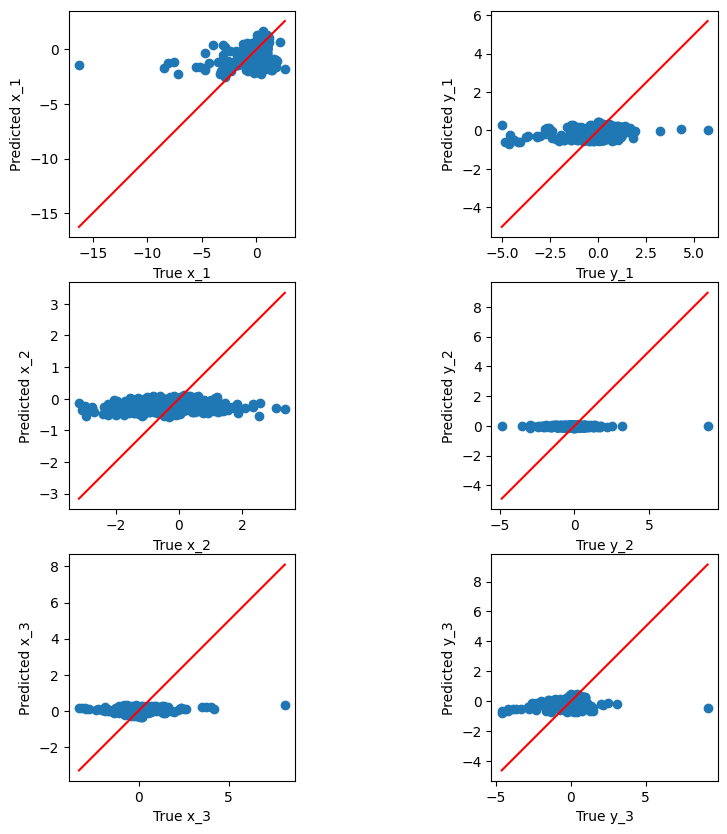

RMSE after eliminating y_3: 1.0326958072461576
Eliminating variable: x_3 (correlation with x_1: 0.7821914759570795)
Train RMSE: 1.192112190988064, Validation RMSE: 1.0326989019104986


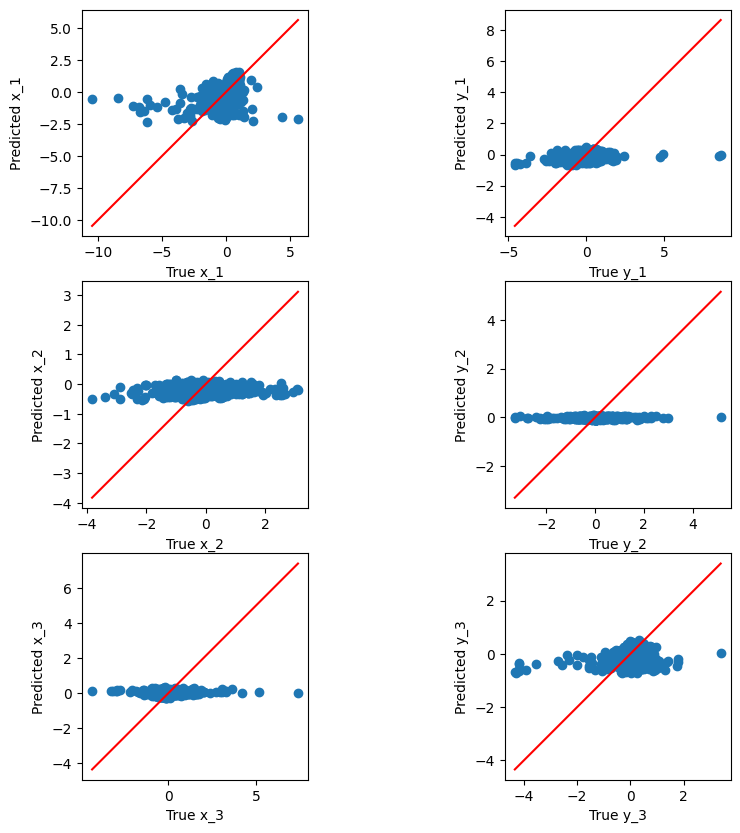

RMSE after eliminating x_3: 1.0326989019104986
Eliminating variable: y_2 (correlation with y_3: 0.7289136467805887)
Train RMSE: 1.1921013332165693, Validation RMSE: 1.032695765570656


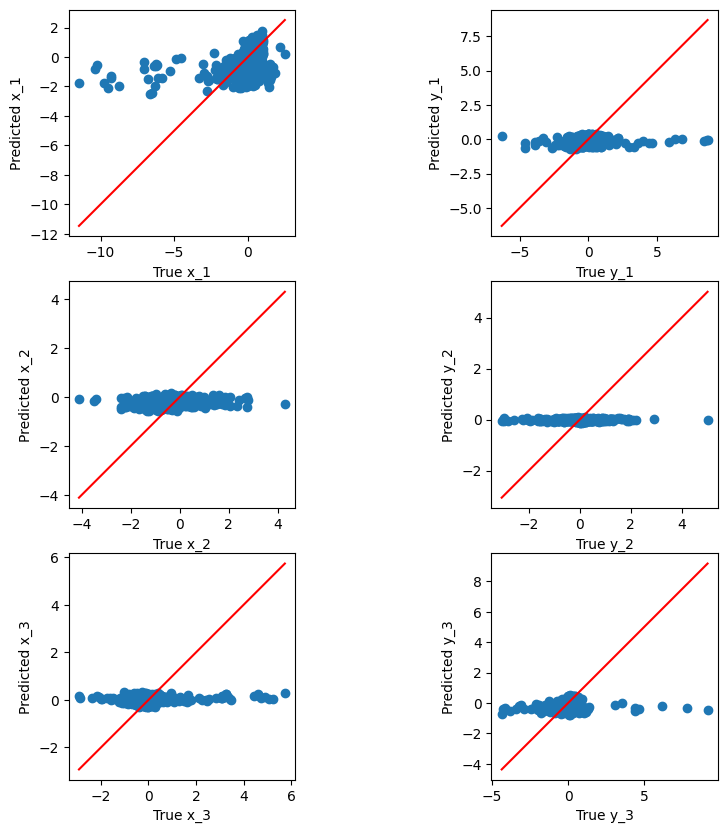

RMSE after eliminating y_2: 1.032695765570656
Eliminating variable: v_x_2 (correlation with v_x_1: 0.6242861572316117)
Train RMSE: 1.1921014754686527, Validation RMSE: 1.032707916742546


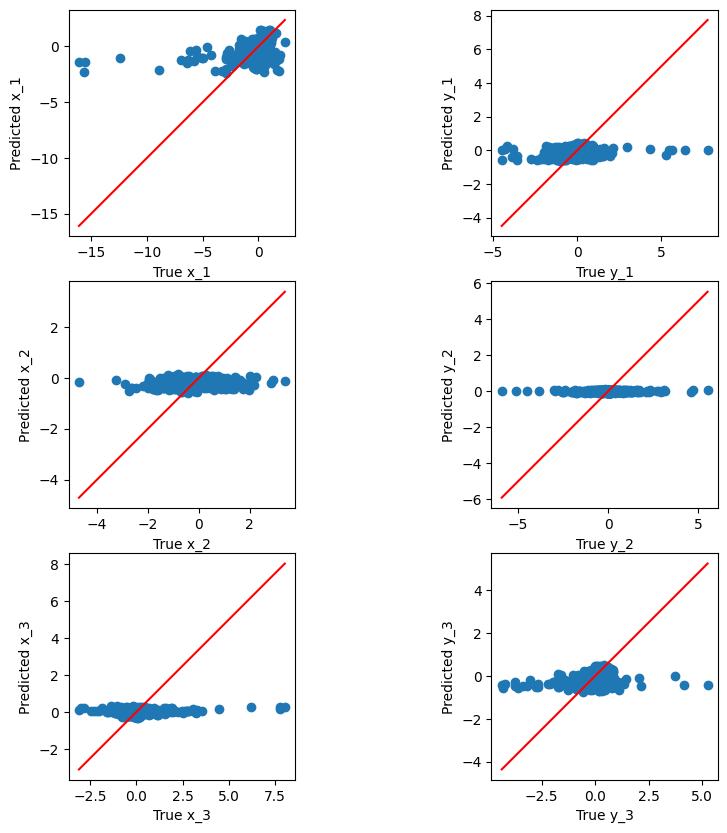

RMSE after eliminating v_x_2: 1.032707916742546
Eliminating variable: v_y_3 (correlation with v_y_2: 0.6235562380253001)
Train RMSE: 1.192101462235618, Validation RMSE: 1.0327076581002383


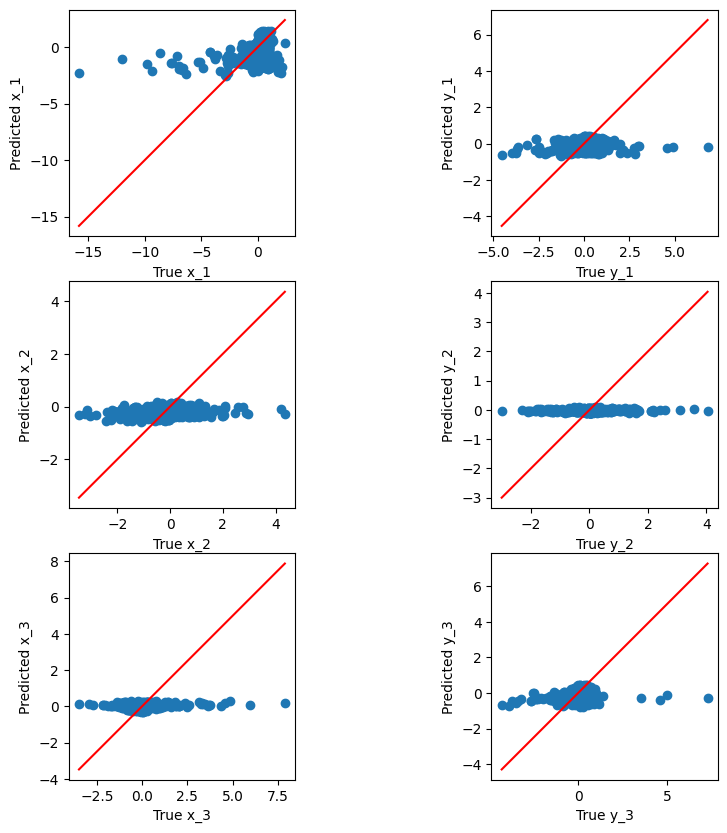

RMSE after eliminating v_y_3: 1.0327076581002383
Eliminating variable: v_y_2 (correlation with v_y_1: 0.5358233121919765)
Train RMSE: 1.1921014754686527, Validation RMSE: 1.032707916742546


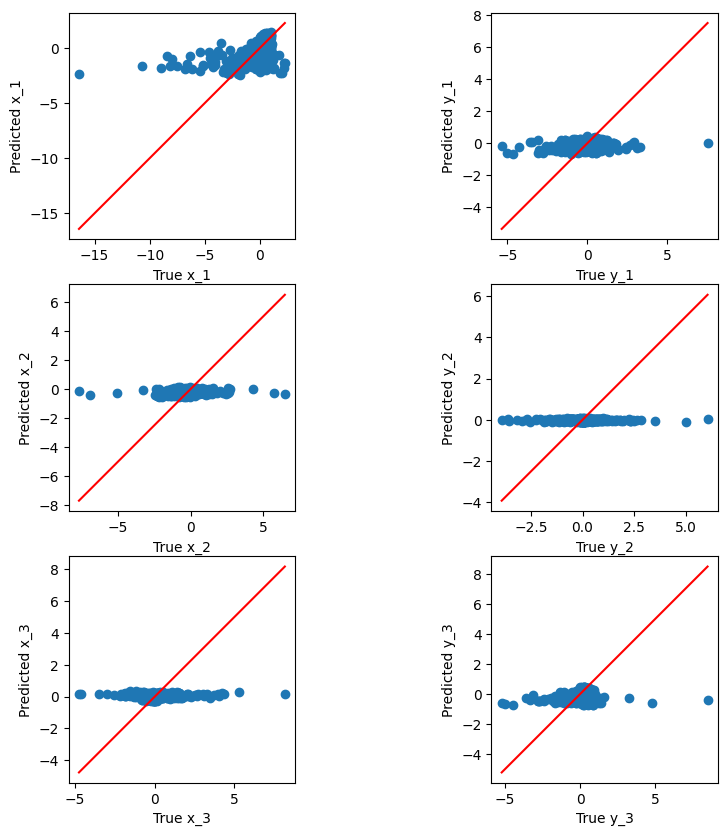

RMSE after eliminating v_y_2: 1.032707916742546
Eliminating variable: x_2 (correlation with x_1: 0.5331592019379877)
Train RMSE: 1.1921127854178077, Validation RMSE: 1.032739119430896


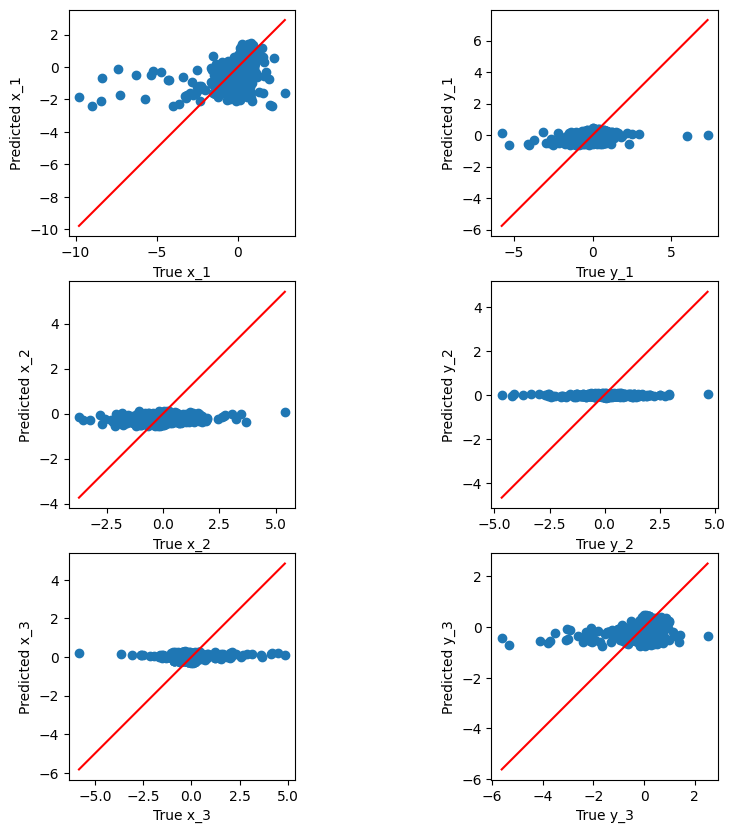

RMSE after eliminating x_2: 1.032739119430896
Eliminating variable: v_x_3 (correlation with v_x_2: 0.4929702826656178)
Train RMSE: 1.192101462235618, Validation RMSE: 1.0327076581002383


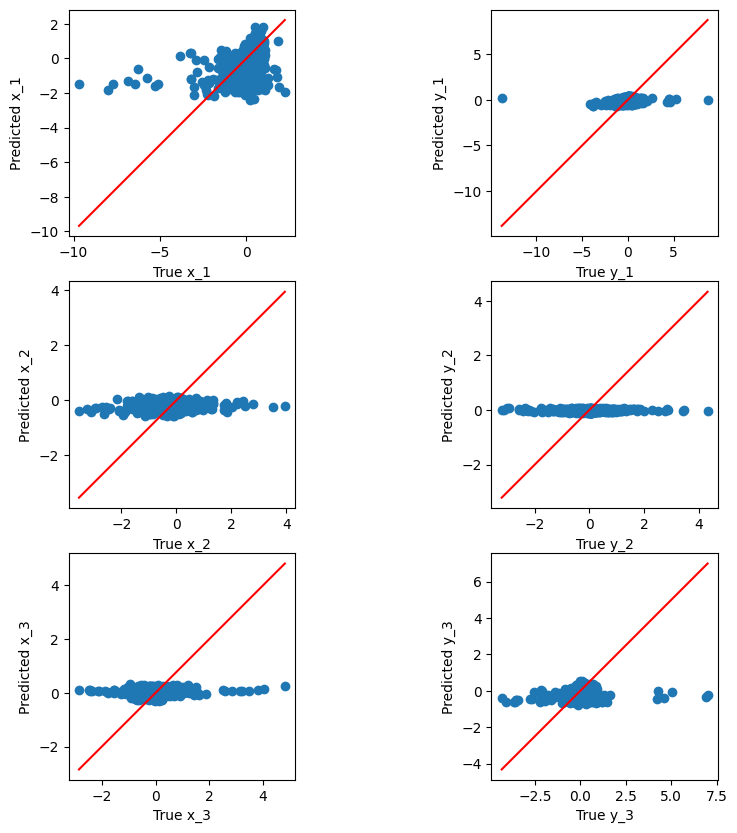

RMSE after eliminating v_x_3: 1.0327076581002383
Eliminating variable: y_1 (correlation with x_2: 0.4839585482978954)
Train RMSE: 1.1921014544083222, Validation RMSE: 1.032708977313107


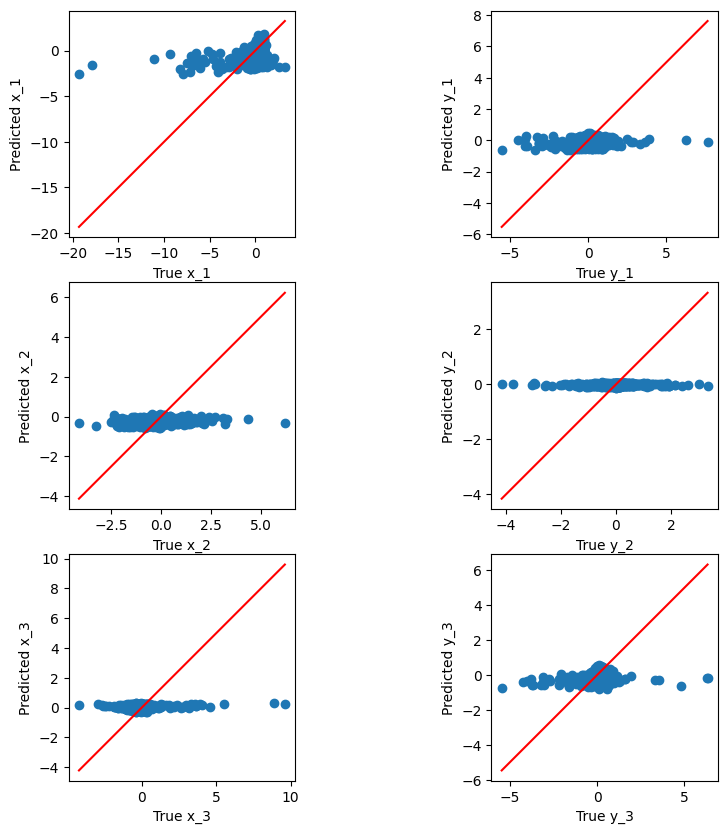

RMSE after eliminating y_1: 1.032708977313107
Eliminating variable: y_2 (correlation with x_3: 0.46529056608527253)
Train RMSE: 1.1921013332165693, Validation RMSE: 1.032695765570656


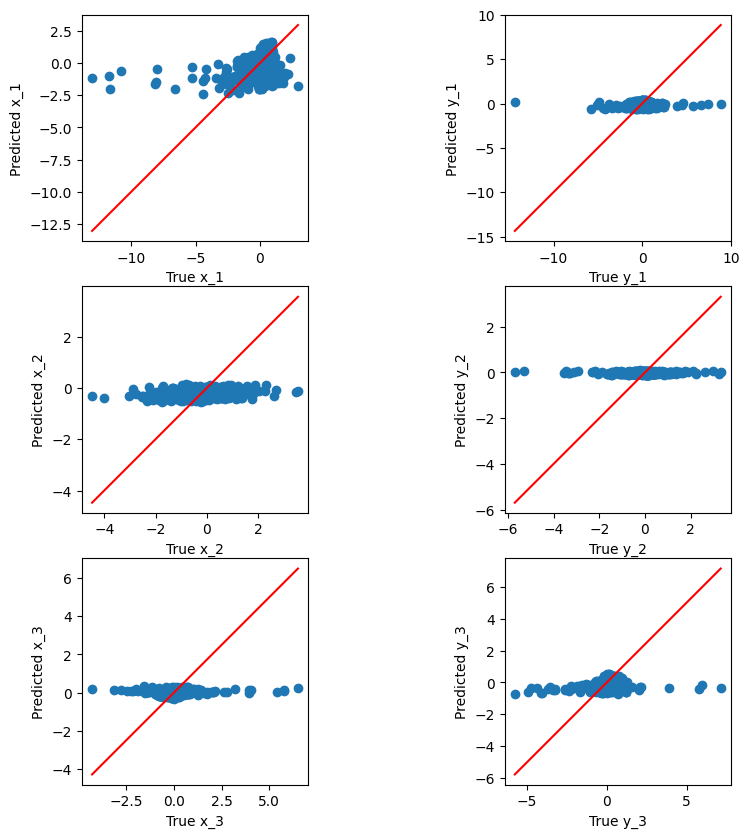

RMSE after eliminating y_2: 1.032695765570656
Eliminating variable: x_3 (correlation with y_3: 0.4557728427528794)
Train RMSE: 1.192112190988064, Validation RMSE: 1.0326989019104986


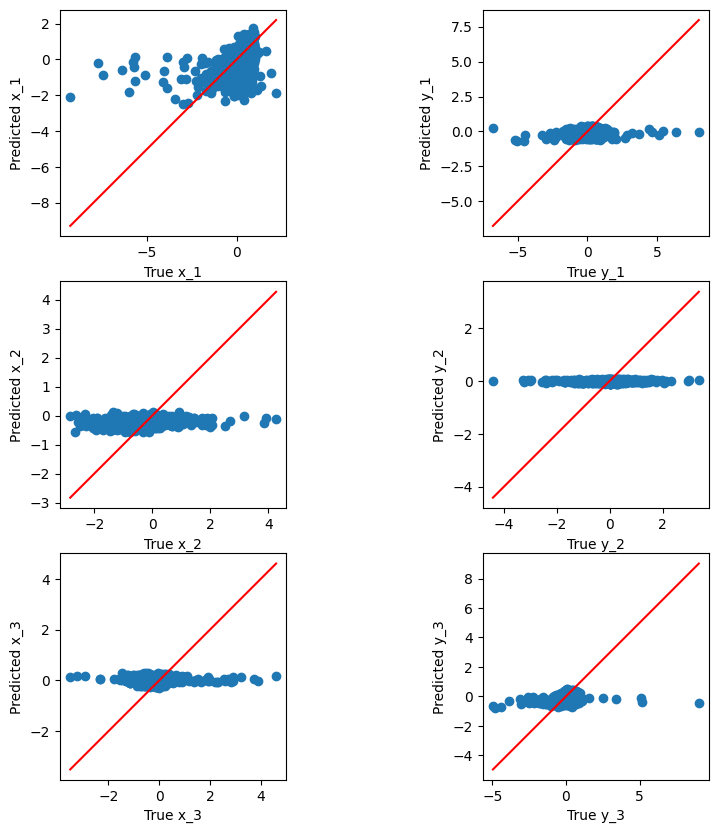

RMSE after eliminating x_3: 1.0326989019104986
Eliminating variable: x_2 (correlation with y_3: 0.42947869773609826)
Train RMSE: 1.1921127854178077, Validation RMSE: 1.032739119430896


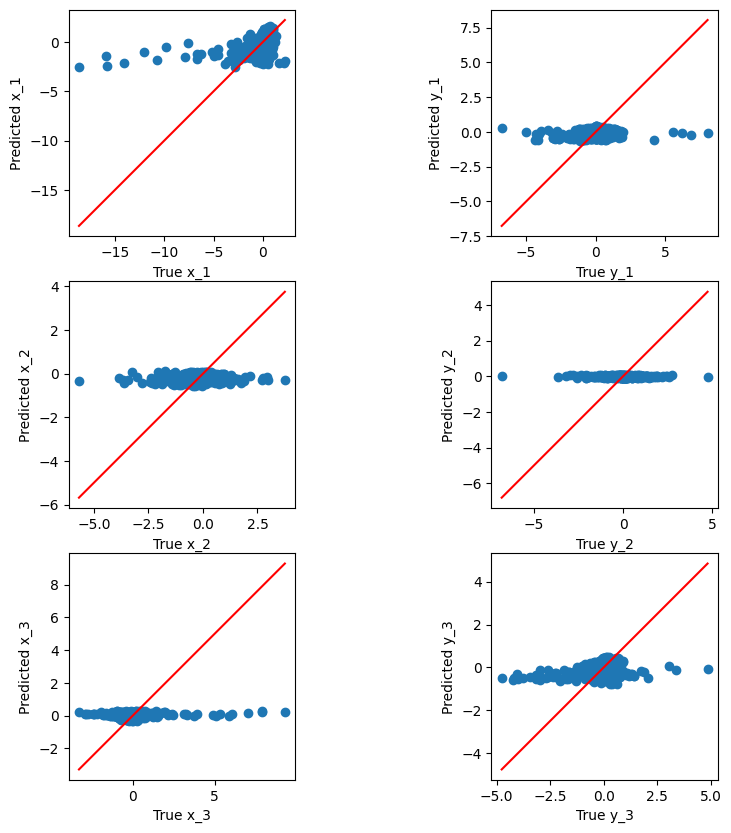

RMSE after eliminating x_2: 1.032739119430896
Eliminating variable: v_x_1 (correlation with v_x_3: 0.3719218267657973)
Train RMSE: 1.1921014544083222, Validation RMSE: 1.032708977313107


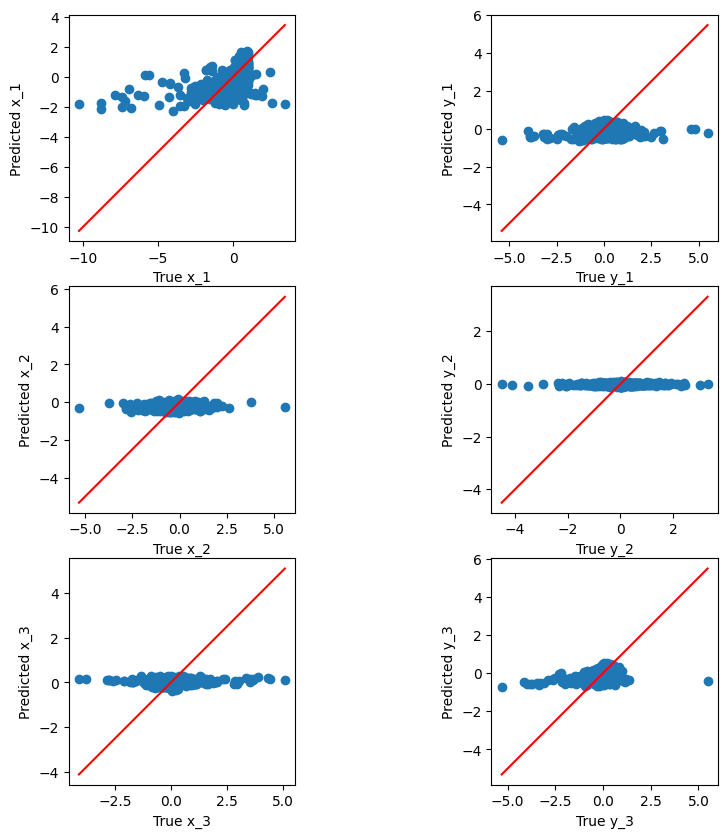

RMSE after eliminating v_x_1: 1.032708977313107
Eliminating variable: v_y_3 (correlation with v_y_1: 0.3259631755007231)
Train RMSE: 1.192101462235618, Validation RMSE: 1.0327076581002383


KeyboardInterrupt: 

In [53]:
# Step 1: Identify the most redundant variables using sorted_corr
# Ignore 't' and 'trajectory_id'
redundant_variables = sorted_corr.drop(index=['t', 'trajectory_id'], level=0).drop(index=['t', 'trajectory_id'], level=1)
redundant_variables = redundant_variables[redundant_variables < 1.0]  # Remove perfect correlations
print(redundant_variables)

# Step 2: Eliminate the most redundant variable one by one and evaluate the model
info_columns = ['trajectory_id', 'Id']
velocity_columns = ['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3']

X_train_reg_FE = X_train.drop(columns=info_columns)
y_train_reg_FE = y_train.drop(columns=info_columns)
X_val_reg_FE = X_val.drop(columns=info_columns)
y_val_reg_FE = y_val.drop(columns=info_columns)

# Function to train and evaluate the model
def train_and_evaluate(X_train, y_train, X_val, y_val, plot_title):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression()) 
    ])
    y_pred_train, y_pred_val, model = train_model(pipeline, X_train, X_val, y_train, y_val)
    train_rmse = root_mean_squared_error(y_pred_train, y_train)
    val_rmse = root_mean_squared_error(y_pred_val, y_val)
    print(f"Train RMSE: {train_rmse}, Validation RMSE: {val_rmse}")
    plot_y_yhat(np.array(y_val), np.array(y_pred_val), plot_title)
    return val_rmse

# Use the already trained linear_model as the baseline model performance
baseline_rmse = root_mean_squared_error(y_pred_val, y_val_reg)
print(f"Baseline RMSE: {baseline_rmse}")

# Step 3: Eliminate redundant variables one by one and evaluate the model
for (var1, var2), corr_value in redundant_variables.items():
    if var1 in X_train_reg_FE.columns and var2 in X_train_reg_FE.columns:
        if corr_value > 0.5:
            print(f"Eliminating variable: {var2} (correlation with {var1}: {corr_value})")
            X_train_reduced = X_train_reg_FE.drop(columns=[var2])
            X_val_reduced = X_val_reg_FE.drop(columns=[var2])
            reduced_rmse = train_and_evaluate(X_train_reduced, y_train_reg_FE, X_val_reduced, y_val_reg_FE, f"Model without {var2}")
            print(f"RMSE after eliminating {var2}: {reduced_rmse}")

## Nonparametric Model - the k-Nearest Neighbors Regressor

In [40]:
info_columns = ['trajectory_id', 'Id']
velocity_columns = ['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3']

X_train_non_parametric = X_train.drop(columns=info_columns+velocity_columns)
y_train_non_parametric = y_train.drop(columns=info_columns+velocity_columns)
X_val_non_parametric = X_val.drop(columns=info_columns+velocity_columns)
y_val_non_parametric = y_val.drop(columns=info_columns+velocity_columns)

In [41]:
def validate_knn_regression(X_train, y_train, X_val, y_val, k=range(1,15)):
    best_rmse = float('inf')
    best_k = None
    training_times = []
    inference_times = []
    rmses = []

    for n_neighbors in k:
        knn = KNeighborsRegressor(n_neighbors=n_neighbors)
        
        # Measure training time
        start_time = time.time()
        knn.fit(X_train, y_train)
        training_time = time.time() - start_time
        training_times.append(training_time)
        
        # Measure inference time
        start_time = time.time()
        y_pred = knn.predict(X_val)
        inference_time = time.time() - start_time
        inference_times.append(inference_time)
        
        rmse = root_mean_squared_error(y_val, y_pred)
        rmses.append(rmse)
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_k = n_neighbors

    print(f"Best k: {best_k}, Best RMSE: {best_rmse}")
    return best_k, best_rmse, training_times, inference_times, rmses

# Example usage:
best_k, best_rmse, training_times, inference_times, rmses = validate_knn_regression(X_train_non_parametric, y_train_non_parametric, X_val_non_parametric, y_val_non_parametric)

Best k: 5, Best RMSE: 0.7795892440305111
